In [71]:
# Gym stuff
# import gym
# import gym_anytrading

# Stable baselines
# Wrap trading environment to pass it to stable baseline
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO

# Processing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
from sb3_contrib import RecurrentPPO

In [73]:
import pandas as pd
df = pd.read_csv(r"..\gym_anytrading\datasets\data\STOCKS_GOOGL.csv")
df.drop(['Adj Close'], axis=1, inplace=True)
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,5291100


In [74]:
import gymnasium as gym
env = gym.make('stocks-v0', df=df, frame_bound=(5,len(df)), window_size=5)
# Frame: portion of data: include first 100 time steps, starting the 10th time step

In [75]:
# env.prices
# env.signal_features

# Build Environment

In [76]:
env.action_space

Discrete(2)

info: {'total_reward': 18.718719482421875, 'total_profit': 0.7262514149016187, 'position': <Positions.Long: 1>}


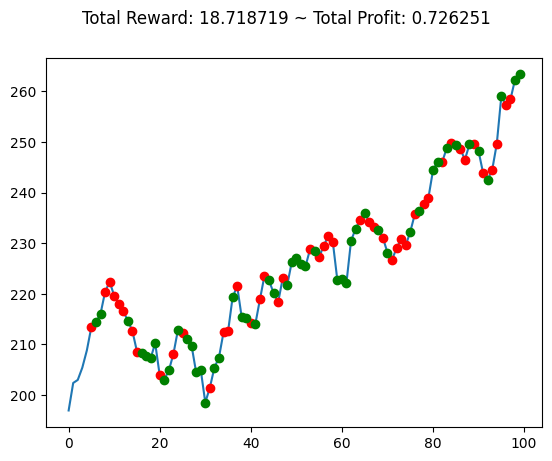

In [77]:
observation = env.reset(seed=2023)
while True:
    # Random steps
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

In [78]:
# Create multiple environments
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5) 
env = DummyVecEnv([env_maker])

In [79]:
model = A2C('MlpPolicy', env, verbose=0, seed=2023)
# model = RecurrentPPO("MlpLstmPolicy", env, verbose=0, seed=2023)
model.learn(total_timesteps=3000)

# env.reset()
# model = A2C('MlpLstmPolicy', env, verbose=0, seed=2023)
# model.learn(total_timesteps=10000)

# Evaluation

In [80]:
env = gym.make('stocks-v0', df=df, frame_bound=(10,140), window_size=5)
obs = env.reset()
while True:
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Short: 0>}


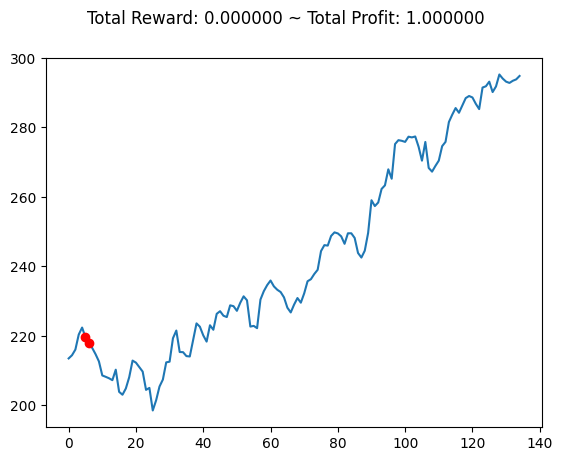

In [81]:
plt.cla()
env.unwrapped.render_all()
plt.show()

# Example 2

In [82]:
import random
import json
import gym
from gym import spaces
import pandas as pd
import numpy as np

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 10000


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.reward_range = (0, MAX_ACCOUNT_BALANCE)

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(6, 6), dtype=np.float16)

    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        frame = np.array([
            self.df.loc[self.current_step - 6 : self.current_step -1, 'Open'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 6: self.current_step -1, 'High'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 6: self.current_step -1, 'Low'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 6: self.current_step -1, 'Close'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step - 6: self.current_step -1, 'Volume'].values / MAX_NUM_SHARES,
            self.df.loc[self.current_step - 6: self.current_step -1, 'VWAP'].values/1069.5784397582636 ,
            self.df.loc[self.current_step - 6: self.current_step -1, 'RSI'].values/96.08478275173084 
        ])
        # Append additional data and scale each value to between 0-1
        # print(self.current_step)
        # print(frame.shape)
        obs1 = np.append(frame, [[
            self.balance / MAX_ACCOUNT_BALANCE,
            self.max_net_worth / MAX_ACCOUNT_BALANCE,
            self.shares_held / MAX_NUM_SHARES,
            self.cost_basis / MAX_SHARE_PRICE,
            self.total_shares_sold / MAX_NUM_SHARES,
            self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),
        ]], axis=0)
        obs =obs1
        return obs

    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(
            self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (
                prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)

        self.current_step += 1

        if self.current_step > len(self.df.loc[:, 'Open'].values) - 6:
            self.current_step = 0

        delay_modifier = (self.current_step / MAX_STEPS)

        reward = self.balance * delay_modifier
        done = self.net_worth <= 0

        obs = self._next_observation()

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(
            0, len(self.df.loc[:, 'Open'].values) - 6)

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [83]:
%pwd

'c:\\Users\\supha\\repos\\cs5756\\RL-Based-Gym-Trading\\examples'

In [85]:
import gym
import json
import datetime as dt

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO
# from env.StockTradingEnv import StockTradingEnv

import pandas as pd

df = pd.read_csv('..\gym_anytrading\datasets\data\STOCKS_GOOGL.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.sort_values('Date')
df = df.reset_index()

# The algorithms require a vectorized environment to run
env = DummyVecEnv([lambda: StockTradingEnv(df)])

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)

obs = env.reset()
for i in range(2000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


ValueError: The environment is of type <class '__main__.StockTradingEnv'>, not a Gymnasium environment. In this case, we expect OpenAI Gym to be installed and the environment to be an OpenAI Gym environment.

In [90]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN

model = DQN('MlpPolicy', DummyVecEnv([lambda: env]), learning_rate=0.001, verbose=1)
model.learn(total_timesteps=1000, log_interval=10)
model.save('nyse_dqn_model.pt')

Using cpu device


In [91]:
model = DQN.load('nyse_dqn_model.pt')

model.set_env(DummyVecEnv([lambda: env]))
model.learn(total_timesteps=1000, log_interval=10)
model.save('nyse_dqn_model.pt')


c:\Users\supha\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [92]:
import pandas as pd

model = DQN.load('nyse_dqn_model.pt')

logs = []
for symbol, data in test_data.items():
    env = DRL4TEnv({ symbol: data })
    model.set_env(DummyVecEnv([lambda: env]))

    obs = env.reset()
    done = False

    log = pd.DataFrame()
    while(not done):
        action, _ = model.predict(obs)
        obs, _, done, info = env.step(action)
        log = pd.concat([log, pd.DataFrame(info, index=[info['Date']])])
    logs.append(log)

NameError: name 'test_data' is not defined